In [14]:
# Import packages needed
import numpy as np
import pandas as pd
import pickle
import os
os.environ["H5PY_DEFAULT_READONLY"] = "1" # Surpress h5py deprecation warnings
import socket
from datetime import datetime
from seticore import viewer # If you don't have it, use pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
import matplotlib.pyplot as plt
import setigen as stg
from astropy import units as u

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
candidates = pd.read_csv("/home/nstiegle/BL-COSMIC-2024-proj/candidate/decent_hits.csv")

In [16]:
groups = candidates.groupby("tstart_h")

In [17]:
# Look for the stamp in a single stamp file
# Assumes the stamp_uri exists 
def find_stamp_in_single_file(stamp_uri, hit_frequency, threshold):
    # Check each stamp in the file to see if it matches
    stamps_gen = viewer.read_stamps(stamp_uri, find_recipe=True)
    for i, stamp in enumerate(stamps_gen):
        assert(stamp != None)
        assert(stamp.recipe != None)
        if abs(stamp.stamp.signal.frequency - hit_frequency) < threshold*1e-6:
            # Found the stamp!
            return i, stamp
    
    # Didn't find the stamp in this whole file of stamps
    return None, None

# Given a stamp_uri, increments the index of the stamp file by one (so if it's /.../...seticore.0000.stamps it goes to /.../...seticore.0001.stamps)
def increment_stamp_uri(stamp_uri):
    split_uri = stamp_uri.split('.')
    assert(split_uri[-1] == 'stamps')
    num = int(split_uri[-2])
    num += 1
    split_uri[-2] = str(num).zfill(4)
    return ".".join(split_uri)

# Finds where the stamp of a given hit is
# Takes:
# - stamp URI (of stamp file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location_helper(stamp_uri, hit_frequency, threshold):
    # Check stamp file passed in exists
    if not os.path.exists(stamp_uri):
        return None, None
    
    # Look for stamp in the stamp file given
    index, stamp = find_stamp_in_single_file(stamp_uri, hit_frequency, threshold)
    if (index != None) and (stamp != None):
        return stamp_uri, index
    else:
        # Check if there's another stamp file (because stamps can get split up into multiple files)
        return find_stamp_location_helper(increment_stamp_uri(stamp_uri), hit_frequency, threshold)

# Finds where the stamp of a given hit is
# Takes:
# - hit URI (of .hits file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location(hit_uri, hit_frequency, threshold=500):
    # Convert a filepath from pointing to a .hits
    # to a .stamps file for the same uri
    # If given a .stamps ending, doesn't change it
    def stamp_filepath_of(hits_filepath):
        return hits_filepath.replace('.hits', '.0000.stamps')

    return find_stamp_location_helper(stamp_filepath_of(hit_uri), hit_frequency, threshold)

In [18]:
hit = candidates.iloc[0]
stamp_uri, index_in_stamp_file = find_stamp_location(hit.file_uri, hit.signal_frequency, threshold=100)
print(stamp_uri)
print(index_in_stamp_file)

/mnt/cosmic-storage-2/data2/vla_target/23B-169.sb44907755.eb44921564.60295.44951556713/23B-169.sb44907755.eb44921564.60295.44951556713.11.1/23B-169.sb44907755.eb44921564.60295.44951556713.11.1.AC.C640.0028.raw.seticore.0000.stamps
34


In [19]:
stamps = [stamp for stamp in viewer.read_stamps(stamp_uri, find_recipe=True)]
stamp = stamps[index_in_stamp_file]

In [20]:
candidates.source_name.unique()

array(['3073619025268414208', 'Incoherent'], dtype=object)

recalculated power: 2.001442e+12
local SNR: 46.05385745484835


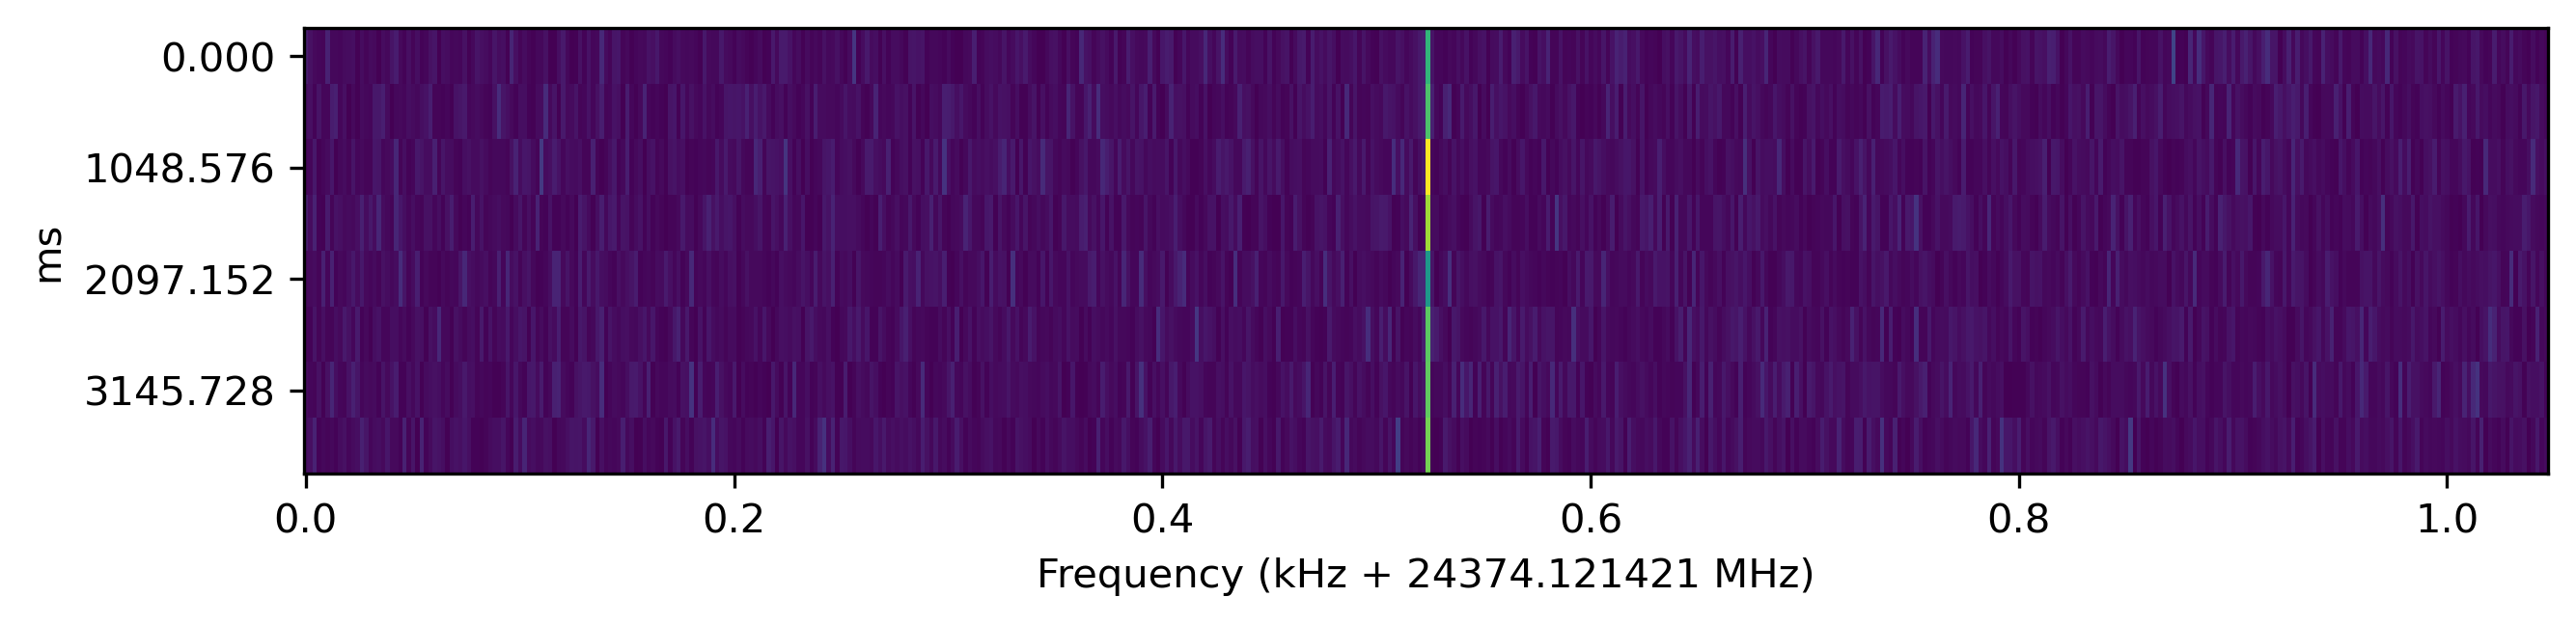

In [21]:
stamp.show_beam(0)

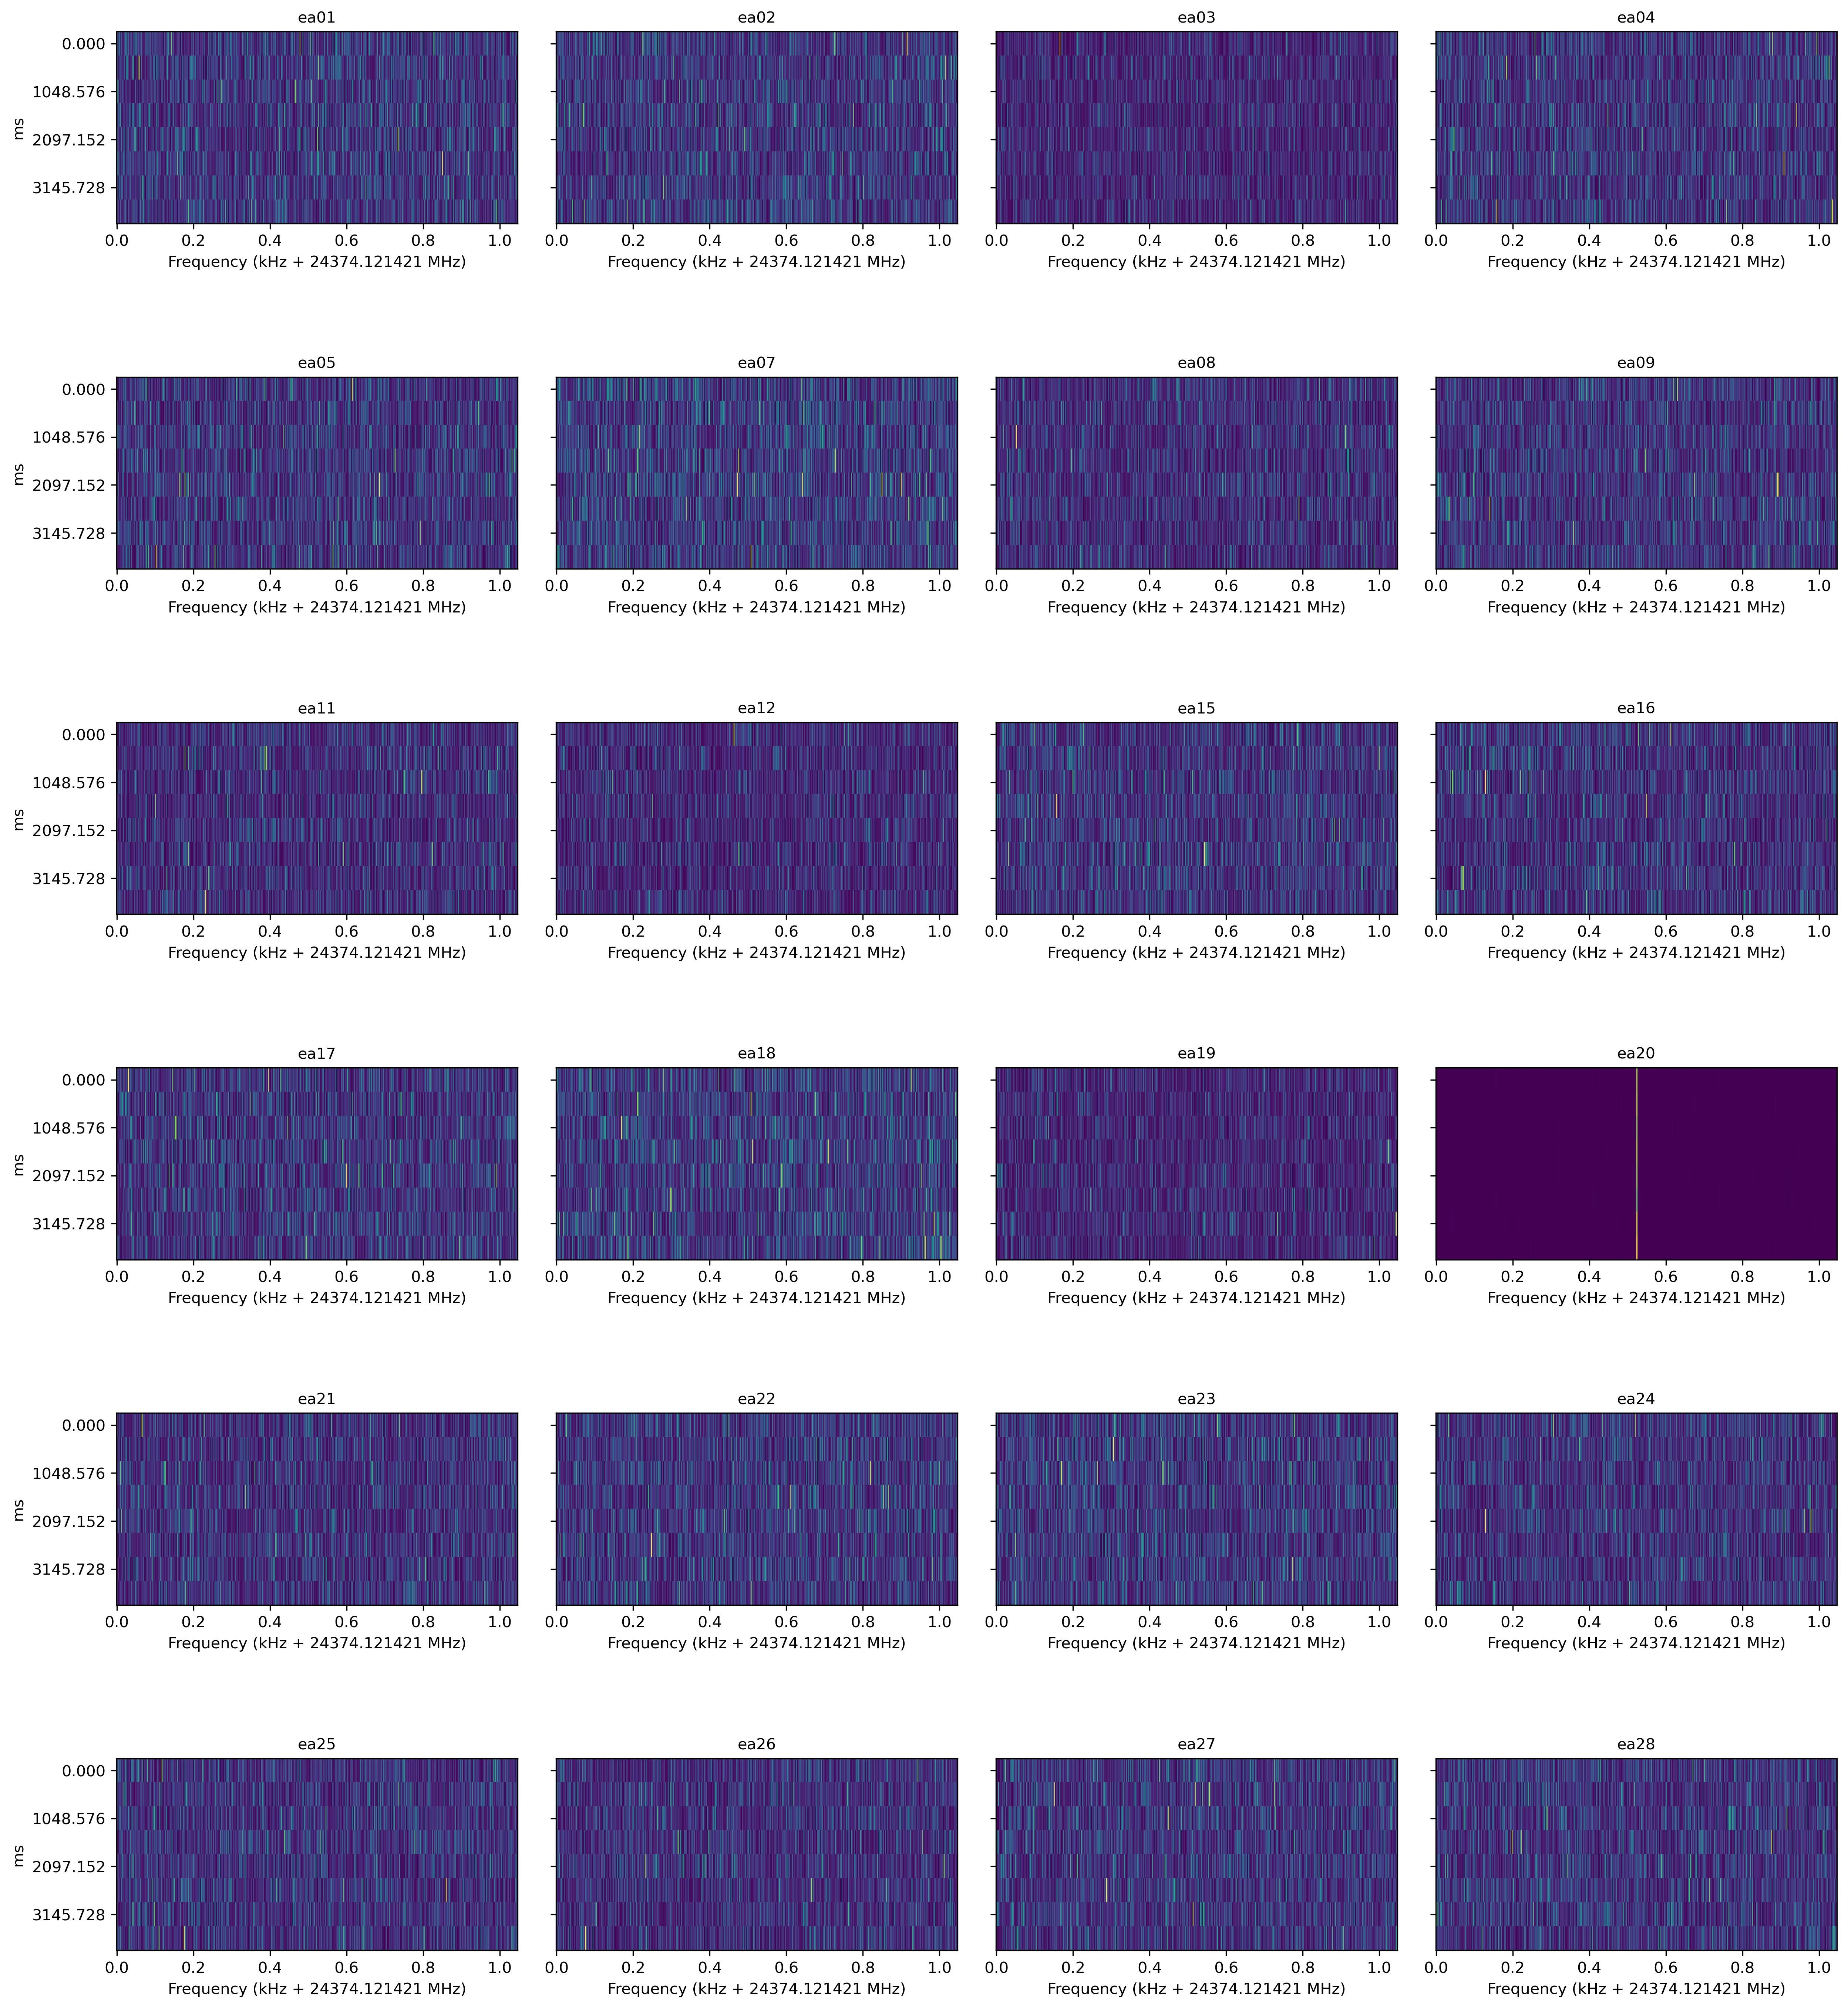

In [22]:
stamp.show_antennas()

In [25]:
hit.signal_frequency

24167.507182502744

recalculated power: 1.904298e+12
local SNR: 187.47704297427626


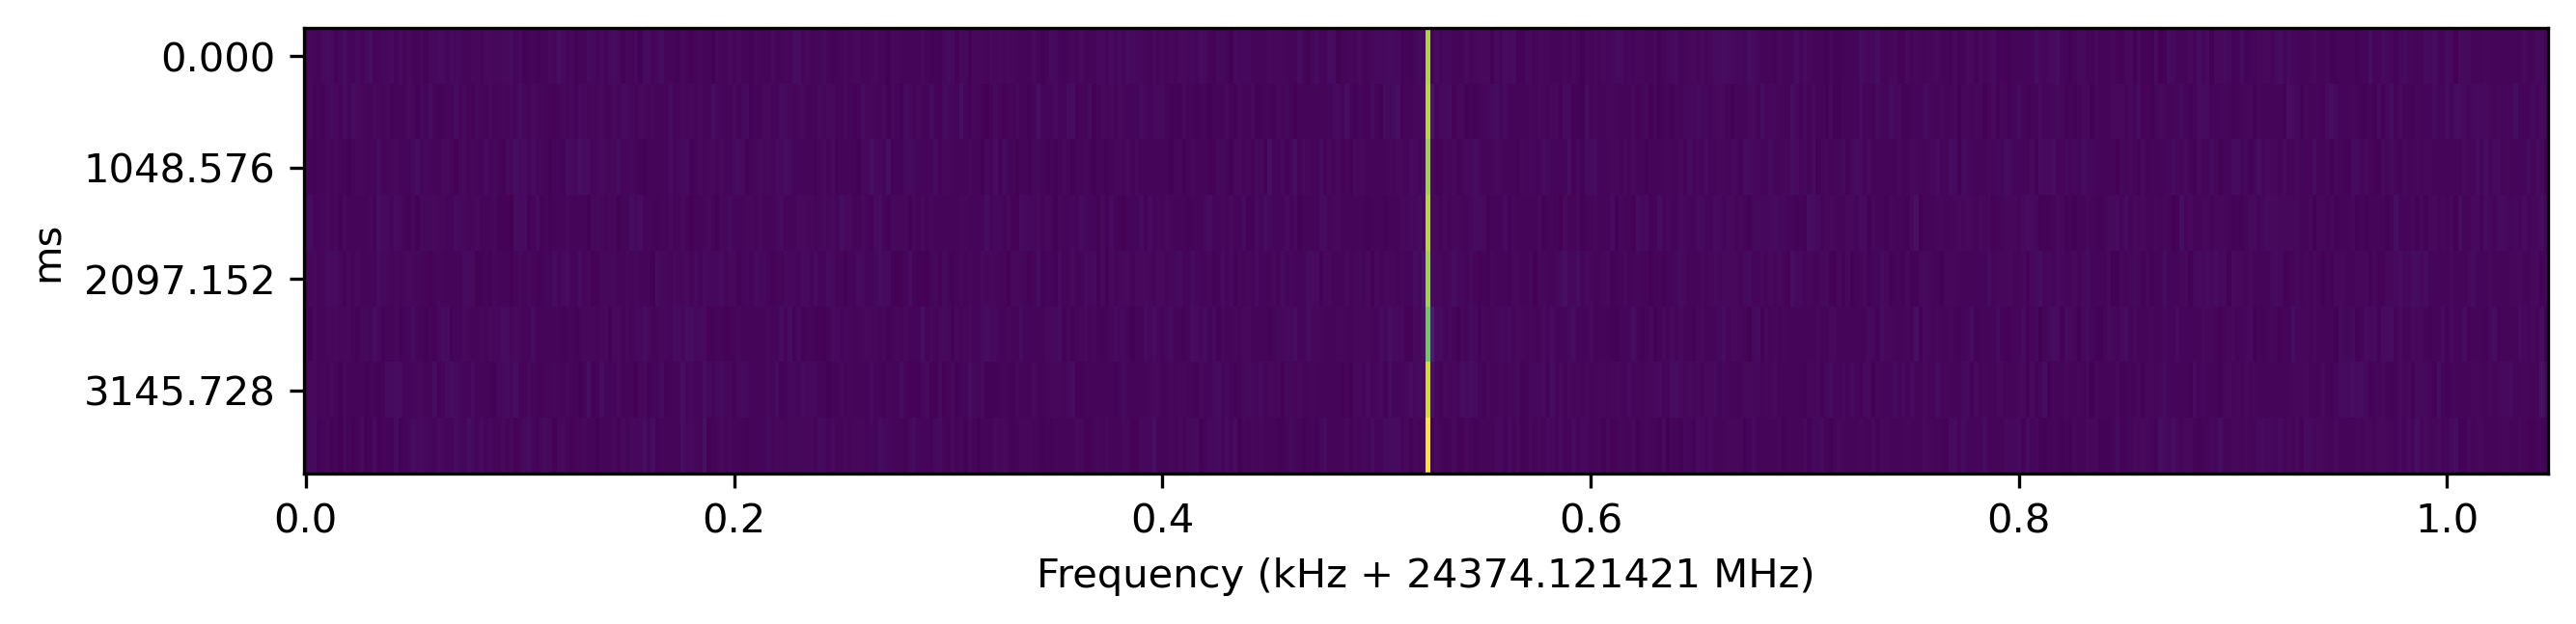

In [28]:
stamp.show_classic_incoherent()

In [31]:
str(hit.tstart)

'60295.52064410598'

In [35]:
first_time = False
for i, hit in candidates.iterrows():
        if not first_time:
                # Make a directory if one doesn't already exist
                main_dir = "/home/nstiegle/BL-COSMIC-2024-proj/candidate/decent_hits/"
                target_dir = main_dir + f"{hit.signal_frequency}GHz_{hit.tstart}days"
                if not os.path.exists(target_dir):
                        os.mkdir(target_dir)
                target_dir = target_dir + "/"

                # Get the stamp
                stamp_uri, index_in_stamp_file = find_stamp_location(hit.file_uri, hit.signal_frequency, threshold=100)
                stamps = [stamp for stamp in viewer.read_stamps(stamp_uri, find_recipe=True)]
                stamp = stamps[index_in_stamp_file]

                # Plot
                if hit.source_name == "Incoherent":
                        stamp.show_classic_incoherent(title=f"{hit.id} Incoherent", show_signal=True, save_to=target_dir + f"Incoherent.png")
                        stamp.show_antennas(title=f"{hit.id} Antennas of Incoherent", show_signal=True, save_to=target_dir + f"Antennas_of_Incoherent.png")
                else:
                        stamp.show_beam(0, title=f"{hit.id} Coherent", show_signal=True, save_to=target_dir + f"coherent.png")
                        stamp.show_antennas(title=f"{hit.id} Antennas of Coherent", show_signal=True, save_to=target_dir + f"Antennas_of_Coherent.png")
                # first_time = True

recalculated power: 2.001442e+12
local SNR: 46.05385745484835
recalculated power: 1.644120e+12
local SNR: 27.985744999707794
recalculated power: 1.684435e+12
local SNR: 57.83892221374192
recalculated power: 1.336821e+12
local SNR: 49.91354366113251
recalculated power: 1.717373e+12
local SNR: 254.07079907778427
recalculated power: 1.616706e+12
local SNR: 190.95507650921178
recalculated power: 1.124055e+12
local SNR: 180.74203347343754
recalculated power: 9.125805e+11
local SNR: 10.560704738778998
recalculated power: 1.720060e+12
local SNR: 29.855658611936956
recalculated power: 9.563842e+11
local SNR: 41.7273545039219
recalculated power: 1.760147e+12
local SNR: 132.1270076543676
recalculated power: 6.097786e+11
local SNR: 7.172977936487878
recalculated power: 6.814164e+11
local SNR: 53.51164554625667
recalculated power: 1.797391e+12
local SNR: 47.35433250566457
recalculated power: 1.787116e+12
local SNR: 245.39318239255695
recalculated power: 4.681808e+11
local SNR: 58.79635559251121
re